--- In this example we run segmentation on a significance image to identify sources.

In [1]:
import numpy as np
from astropy.io import fits

In [2]:
image_dir = 'data' # define image directory relative to this script

In [3]:
f = 'f125w' # filter

In [4]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [5]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [6]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [7]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [8]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image. Segmentation identifies groups of connected pixels which are all above some threshold.

In [9]:
from photutils import detect_sources

In [10]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [11]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

In [12]:
print(f'total number of sources in original map: {segm.max_label}')
# print(f'total number of sources in original map: {segm.nlabels}') # also works
# print(f'total number of sources in original map: {np.max(segm.data)}') # also works

total number of sources in original map: 20


The segmentation image has the same dimensions as the input image. Each pixel in the segmentation image has an integer value. If $p_{i,j}=0$ this means that pixel isn't associated with a source. If $p_{i,j}>0$ that pixel is part of an object. Using imshow on the segmentation map will automatically colour each image by a different colour.

In [13]:
import matplotlib.pyplot as plt

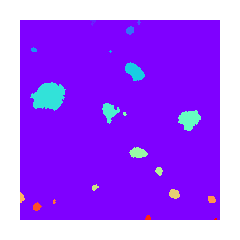

In [14]:
fig = plt.figure(figsize = (1, 1), dpi = segm.data.shape[0])
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(segm, cmap = 'rainbow')
plt.show()
fig.savefig('segm.png')

If two sources overlap simple segmentation can merge them together. This can be over-come using de-blending

In [15]:
from photutils import deblend_sources

In [16]:
segm_deblend = deblend_sources(sig, segm, npixels=npixels, nlevels=32, contrast=0.001)

In [17]:
print(f'total number of sources in debelended map: {segm_deblend.max_label}')

total number of sources in debelended map: 24


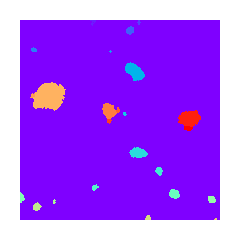

In [18]:
fig = plt.figure(figsize = (1, 1), dpi = segm_deblend.data.shape[0])
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(segm_deblend, cmap = 'rainbow')
plt.show()
fig.savefig('segm_deblend.png')